Installazione dei pacchetti necessari.

In [ ]:
%%capture
%pip install mwparserfromhell
%pip install lxml
%pip install pyspark
%pip install nltk
%pip install numba
%pip install pandas
%pip install matplotlib
%pip install scipy
%pip install scikit-learn

Importazioni varie.

In [2]:
import csv
import re
import os.path
import shutil
import pandas as pd
import glob
import mwparserfromhell
import nltk
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

from nltk.corpus import stopwords
from lxml import etree
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, explode, split, regexp_replace, sum, substring, regexp_extract
from pyspark.sql.types import IntegerType


Download delle stopwords.

In [2]:
%%capture
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/fabbro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Controlliamo l'esistenza del file da analizzare.

In [3]:
for file in os.listdir():
    if file.startswith("enwiki") and file.endswith(".xml"):
        os.rename(file, "file.xml")
if not os.path.exists("file.xml"):
    raise SystemExit("File not exists! Aborting...")
else:
    print("File exists! Continuing...")

File exists! Continuing...


----

Esempio sul funzionamento.

In [4]:
%%capture
def removeNestedParentheses(s):
    lines = s.split('\n')
    print(len(lines))
    ret = []
    for line in lines:
        curr_line = ''
        skip = 0
        for i in line:
            if i == '[':
                skip += 1
            elif i == ']'and skip > 0:
                skip -= 1
            elif skip == 0:
                curr_line += i
        ret.append(curr_line+"\n")
    return '\n'.join(ret)

text = '''
I has a template! {{foo|bar|baz|eggs=spam}} See it <nowiki>or no<!-- revealed --></nowiki>[[File:wiki.png|thumb|Wikipedia logo]]? [[fox]] and [[dog|puppy]] New York also has [[public transport|public transportation]].


New York is a state in the Northeastern United States and is the 27th-most extensive, fourth-most populous, and seventh-most densely populated U.S. state. New York is bordered by New Jersey and Pennsylvania to the south and Connecticut, Massachusetts, and Vermont to the east. The state has a maritime border in the Atlantic Ocean with Rhode Island, east of Long Island, as well as an international border with the Canadian provinces of Quebec to the north and Ontario to the west and north. The state of New York, with an estimated 19.8 million residents in 2015, is often referred to as New York State to distinguish it from New York City, the state's most populous city and its economic hub.
With an estimated population of 8.55 million in 2015, New York City is the most populous city in the United States and the premier gateway for legal immigration to the United States. The New York City Metropolitan Area is one of the most populous urban agglomerations in the world. New York City is a global city, exerting a significant impact upon commerce, finance, media, art, fashion, research, technology, education, and entertainment, its fast pace defining the term New York minute. The home of the United Nations Headquarters, New York City is an important center for international diplomacy and has been described as the cultural and financial capital of the world, as well as the world's most economically powerful city. New York City makes up over 40% of the population of New York State. Two-thirds of the state's population lives in the New York City Metropolitan Area, and nearly 40% live on Long Island. Both the state and New York City were named for the 17th century Duke of York, future King James II of England. The next four most populous cities in the state are Buffalo, Rochester, Yonkers, and Syracuse, while the state capital is Albany.
The earliest Europeans in New York were French colonists and Jesuit missionaries who arrived southward from settlements at Montreal for trade and proselytizing. New York had been inhabited by tribes of Algonquian and Iroquoian-speaking Native Americans for several hundred years by the time Dutch settlers moved into the region in the early 17th century. In 1609, the region was first claimed by Henry Hudson for the Dutch, who built Fort Nassau in 1614 at the confluence of the Hudson and Mohawk rivers, where the present-day capital of Albany later developed. The Dutch soon also settled New Amsterdam and parts of the Hudson Valley, establishing the colony of New Netherland, a multicultural community from its earliest days and a center of trade and immigration. The British annexed the colony from the Dutch in 1664. The borders of the British colony, the Province of New York, were similar to those of the present-day state.
Many landmarks in New York are well known to both international and domestic visitors, with New York State hosting four of the world's ten most-visited tourist attractions in 2013: Times Square, Central Park, Niagara Falls (shared with Ontario), and Grand Central Terminal. New York is home to the Statue of Liberty, a symbol of the United States and its ideals of freedom, democracy, and opportunity. In the 21st century, New York has emerged as a global node of creativity and entrepreneurship, social tolerance, and environmental sustainability. New York's higher education network comprises approximately 200 colleges and universities, including Columbia University, Cornell University, New York University, and Rockefeller University, which have been ranked among the top 35 in the world.


== History ==


=== 16th century ===
In 1524, Giovanni da Verrazzano, an Italian explorer in the service of the French crown, explored the Atlantic coast of North America between the Carolinas and Newfoundland, including New York Harbor and Narragansett Bay. On April 17, 1524 Verrazanno entered New York Bay, by way of the Strait now called the Narrows into the northern bay which he named Santa Margherita, in honour of the King of France's sister. Verrazzano described it as "a vast coastline with a deep delta in which every kind of ship could pass" and he adds: "that it extends inland for a league and opens up to form a beautiful lake. This vast sheet of water swarmed with native boats". He landed on the tip of Manhattan and perhaps on the furthest point of Long Island. Verrazanno's stay in this place was interrupted by a storm which pushed him north towards Martha's Vineyard.
In 1540 French traders from New France built a chateau on Castle Island, within present-day Albany; due to flooding, it was abandoned the next year. In 1614, the Dutch under the command of Hendrick Corstiaensen, rebuilt the French chateau, which they called Fort Nassau. Fort Nassau was the first Dutch settlement in North America, and was located along the Hudson River, also within present-day Albany. The small fort served as a trading post and warehouse. Located on the Hudson River flood plain, the rudimentary "fort" was washed away by flooding in 1617, and abandoned for good after Fort Orange (New Netherland) was built nearby in 1623.


=== 17th century ===

Henry Hudson's 1609 voyage marked the beginning of European involvement with the area. Sailing for the Dutch East India Company and looking for a passage to Asia, he entered the Upper New York Bay on September 11 of that year. Word of his findings encouraged Dutch merchants to explore the coast in search for profitable fur trading with local Native American tribes.
During the 17th century, Dutch trading posts established for the trade of pelts from the Lenape, Iroquois, and other tribes were founded in the colony of New Netherland. The first of these trading posts were Fort Nassau (1614, near present-day Albany); Fort Orange (1624, on the Hudson River just south of the current city of Albany and created to replace Fort Nassau), developing into settlement Beverwijck (1647), and into what became Albany; Fort Amsterdam (1625, to develop into the town New Amsterdam which is present-day New York City); and Esopus, (1653, now Kingston). The success of the patroonship of Rensselaerswyck (1630), which surrounded Albany and lasted until the mid-19th century, was also a key factor in the early success of the colony. The English captured the colony during the Second Anglo-Dutch War and governed it as the Province of New York. The city of New York was recaptured by the Dutch in 1673 during the Third Anglo-Dutch War (1672–1674) and renamed New Orange. It was returned to the English under the terms of the Treaty of Westminster a year later.


== References ==


== Further reading ==

French, John Homer (1860). Historical and statistical gazetteer of New York State. Syracuse, New York: R. Pearsall Smith. OCLC 224691273. (Full text via Google Books.)
New York State Historical Association (1940). New York: A Guide to the Empire State. New York City: Oxford University Press. ISBN 978-1-60354-031-5. OCLC 504264143. (Full text via Google Books.)


== External links ==
New York at DMOZ
 Geographic data related to New York at OpenStreetMap'''



section_title_re = re.compile("^=+\s+.*\s+=+$")
content = ''
skip = False

for l in text.splitlines():
    line = l.strip()
    if "= references =" in line.lower():
        skip = True  # replace with break if this is the last section
        break
    if "= further reading =" in line.lower():
        skip = True  # replace with break if this is the last section
        continue
    if section_title_re.match(line):
        skip = False
        continue
    if skip:
        continue
    content+=line+'\n'
    
""" for x in content:
    if x != "":
        print(x.lower()+"\n")
 """
 
withoutPipeLinks = (re.sub(r"\[\[[^|\]]*\|([^|\]]*)]]", r"\1", content, flags=re.S))
withOutComments= re.sub('<!--.*?-->', '', withoutPipeLinks, flags=re.S)
cleaned= re.sub('<.*?>', '', withOutComments, flags=re.S)
testoPulito = removeNestedParentheses(cleaned)
wikicode = mwparserfromhell.parse(testoPulito)
templates = wikicode.filter_templates()
text = " ".join([testo for testo in testoPulito.split() if testo not in templates])
print(text)

----

<h1>Processamento del testo</h1>

Metodo creato per pulire il file, mantenendo soltanto le parole, eliminando tutti i tag (parentesi quadrate, ad esempio) e tutti i simboli di punteggiatura.
Inoltre vado anche a cancellare i paragrafi ed i loro titoli. 

In [5]:
def removeNestedParentheses(s):
    lines = s.split('\n')
    ret = []
    for line in lines:
        curr_line = ''
        skip = 0
        for i in line:
            if i == '[' or i == '{' :
                skip += 1
            elif (i == ']' or i == '}' ) and skip > 0:
                skip -= 1
            elif skip == 0:
                curr_line += i
        ret.append(curr_line+"\n")
    return '\n'.join(ret)

def cleanUp(text):
    section_title_re = re.compile("^=+\s+.*\s+=+$")
    content = ''
    skip = False

    for l in text.splitlines():
        line = l.strip()
        if "= references =" in line.lower():
            skip = True
            break
        if "= further reading =" in line.lower():
            skip = True 
            continue
        if section_title_re.match(line):
            skip = False
            continue
        if skip:
            continue
        content+=line+'\n'
    
    withoutPipeLinks = (re.sub(r"\[\[[^|\]]*\|([^|\]]*)]]", r"\1", content, flags=re.S))
    withOutComments= re.sub('<!--.*?-->', '', withoutPipeLinks, flags=re.S)
    cleaned= re.sub('<.*?>', '', withOutComments, flags=re.S)
    testoPulito = removeNestedParentheses(cleaned)
    wikicode = mwparserfromhell.parse(testoPulito)
    templates = wikicode.filter_templates()
    text = " ".join([testo for testo in testoPulito.split() if testo not in templates])
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    if text == "":
        return "NullTextFound"
    else:
        return text

Metodo destinato ad eliminare tutte le <i>stop words</i>.

In [6]:
stop_words = set(stopwords.words("english"))
def remove_w(text):
    return ' '.join(w for w in text.split() if w not in stop_words)

Creazione di un file csv contenente i titoli della pagina e le parole contenute all'interno del file XML - [file.xml](./file.xml).
\
Tengo conto dei primi 1000000 elementi.

In [7]:
fileWords = open("fileWords.csv", "w+")
fileTitles = open("fileTitles.csv", "w+")

wordsWriter = csv.writer(fileWords)
titlesWriter = csv.writer(fileTitles)

titlesWriter.writerow(["index", "title"])
wordsWriter.writerow(["index", "text"])
section_title_re = re.compile("^=+\s+.*\s+=+$")
skip = False

i = 0
j = 0
totalCount = 0
titles_list = []
words_list = []
file_xml= ''
if os.path.isfile("fileWiki.xml"):
    file_xml = "fileWiki.xml"
elif os.path.isfile("file.xml"):
    file_xml = "file.xml"
else:
    print("File non trovato")
tupla_titolo = ()
tupla_testo = ()
for event, elem in etree.iterparse(file_xml):
    text = ""
    title=""
    
    if('title' in str(elem.tag)):
        if(elem.text is not None):
            i = i+1
            title = elem.text.lower()
            titlesWriter.writerow([i, title])

    if('text' in str(elem.tag)):
        if(elem.text is not None):
            j = j+1
            text = remove_w(cleanUp(elem.text.lower()))
            wordsWriter.writerow([j, text])

    if j == 1000000 and i == 1000000:
        break
    elem.clear()
    totalCount += 1
    if totalCount > 1 and (totalCount % 1000) == 0:
            percents = (totalCount/1000000)*100
            print(f"Percents: {percents:.2f}%", end="\r")
            if percents == 100:
                break

print("-------------------------------------------DONE------------------------------------------------------")

-------------------------------------------DONE------------------------------------------------------


---

<h1> Analisi dei dati </h1>

Inizializziamo Spark.

In [3]:
%%capture
spark = SparkSession.builder.appName("mySparkApp").config("spark.driver.memory", "4g").config("spark.driver.maxResultSize", "8g").getOrCreate()

23/04/26 17:57:04 WARN Utils: Your hostname, tayler resolves to a loopback address: 127.0.1.1; using 192.168.213.69 instead (on interface wlp0s20f3)
23/04/26 17:57:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/26 17:57:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


<b> Carico i due file come DataFrame </b> tramite pySpark <i> unendoli poi in un unico DF tenendo come chiave d'unione l'index</i>. 
\
Vado quindi a pulire quel che é stato generato (una cartella) mantenendo solo quel che ci serve a noi: il file [rawMerged.csv](./rawMerged.csv) con i dati.
\
<i> Attenzione: se esiste ancora una cartella di nome [merged_file](./merged_file), essa verrá cancellata per evitare conflitti o errori. </i>

In [9]:
%%capture
if os.path.isdir("merged_file"):
    shutil.rmtree("merged_file")

titles_df = spark.read.csv("fileTitles.csv", header=True, inferSchema=True)
text_df = spark.read.csv("fileWords.csv", header=True, inferSchema=True)

merged_df = titles_df.join(text_df, "index")

# riduco il numero di cartelle create a 1
merged_df.coalesce(1).write.csv("merged_file", header=True)

for filename in os.listdir("merged_file"):
    if filename.endswith(".csv"):
        old_path = os.path.join("merged_file", filename)
        new_path = os.path.join("", "rawMerged.csv")
        os.rename(old_path, new_path)
        shutil.rmtree("merged_file")

Ora bisogna mappare le parole (contando quante ce ne sono) presenti in ogni cella del file [rawMerged.csv](./rawMerged.csv). Tiene conto quindi del titolo, la parola che é presente in quella pagina e quante volte viene utilizzata in quel titolo.

In [10]:
%%capture
df = spark.read.format("csv").option("header", "true").load("rawMerged.csv")
df = df.select("title", lower("text").alias("text"))

# alias ci serve per rinominare la colonna, regexp per eliminare tutti gli eventuali caratteri che non sono lettere e explode per espandere le varie liste presenti
words_df = df.select("title", explode(split(regexp_replace("text", r'\W+', ' '), ' ')).alias("word"))

word_counts = words_df.groupBy("title", "word").count().orderBy("count", ascending=False)
word_counts.write.csv("countedWordsDir", mode="overwrite", header=True)

23/04/26 17:41:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/26 17:41:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/26 17:41:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/26 17:41:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/26 17:41:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/26 17:41:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/26 17:41:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/26 17:41:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/04/26 17:41:07 WARN RowBasedKeyValueBatch: Calling spill() on

Vado ad unire tutti i files CSV creati precedentemente eliminando quindi la cartella che li conteneva.
\
Verrá creato un file CSV con il nome [countedWords.csv](./countedWords.csv).

In [11]:
%%capture
csv_files = glob.glob("countedWordsDir/*.csv")

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# unisco i dataframe in uno solo
merged_df = pd.concat(dfs)

merged_df.to_csv("countedWords.csv", index=False)

shutil.rmtree("countedWordsDir")

Quante volte sono state utilizzate le singole parole? 
\
Salviamo il risultato, poi, nel file [singleWordCounted.csv](./singleWordCounted.csv), unendo i file precedentemente generati separatamente.

In [12]:
%%capture
df = spark.read.format("csv").option("header", "true").load("countedWords.csv")

# raggruppo le righe in base alla colonna "word" e somma la colonna "count"
sum_df = df.groupBy("word").agg(sum("count").alias("total_count"))
sum_df = sum_df.withColumn("total_count", sum_df["total_count"].cast("int"))

sum_df.write.mode("overwrite").csv("paroleContate", header=True)

# unisco i vari file
csv_files = glob.glob("paroleContate/*.csv")

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

merged_df = pd.concat(dfs)
merged_df.to_csv("singleWordCounted.csv", index=False)

shutil.rmtree("paroleContate")

Elimino la colonna che ci é inutile (la colonna count) salvando il risultato su un ultimo file finale, da analizzare.

In [13]:
%%capture
df = pd.read_csv('countedWords.csv')

# elimino count, é una colonna, l'operazione viene eseguita sul df senza creare una copia
df.drop('count', axis=1, inplace=True)

df.to_csv('finalFileToAnalyze.csv', index=False)

Leggiamo tutte le parole presenti nella colonna "word" del file [finalFileToAnalyze.csv](./finalFileToAnalyze.csv). Utilizziamo un set in quanto non vogliamo che ci siano parole ripetute. Poi lo trasformiamo in una lista per renderlo indicizzabile.

In [4]:
df = pd.read_csv('finalFileToAnalyze.csv')
word_list = []
for row in df['word']:
    words = re.findall(r'\w+', str(row).lower())
    word_list.extend(words)

word_list = list(set(word_list))

> <b>L’OUTPUT DEVE CONTENERE, PER OGNI PAROLA, LA LISTA DI PAGINE DI WIKIPEDIA CHE CONTENGONO QUELLA PAROLA</b>

Dovremmo utilizzare [finalFileToAnalyze.csv](./finalFileToAnalyze.csv) per le analisi.
\
Analizzo quali parole sono presenti nel file finale da controllare. Se le parole sono presenti, aggiungo il titolo ad una lista.
\
Si creerá infine un file [results.csv](./results.csv) due colonne:
- word: la parola che stiamo analizzando
- titles: la lista di titoli

In [5]:
with open('finalFileToAnalyze.csv', newline='') as csv_file:
    reader = csv.DictReader(csv_file)

    # uso un dizionario per mantenere le associazioni tra parole e titoli
    word_title_dict = {}
    for row in reader:
        title = row['title']
        word = row['word']
        if word not in word_title_dict:
            word_title_dict[word] = []
        word_title_dict[word].append(title)

with open('results.csv', mode='w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    # header
    writer.writerow(['word', 'titles'])
    for word in word_list:
        if word in word_title_dict:
            titles = word_title_dict[word]
        else:
            titles = []
        writer.writerow([word, titles])

Creo un file [titlesSize.csv](./titlesSize.csv) contenente due colonne:
- <i>word</i> che contiene la parola
- <i>list_size</i> che indica la grandezza della lista

In [6]:
df = pd.read_csv('results.csv')

# creo una nuova colonna con la grandezza della lista
df['list_size'] = df['titles'].apply(lambda x: len(x.split(',')))

# creo un nuovo df con le colonne "word" e "list_size" in modo da associare parola e grandezza della lista dei titoli
new_df = df[['word', 'list_size']].copy()

new_df.to_csv('titlesSize.csv', index=False)

Creo un file [occurrences.csv](./occurrences.csv) contenente due colonne:
- <i>list_size</i> che contiene il numero di parole che ci sono nella lista
- <i>occurences</i> che contiene la frequenza del numero di parole

In [7]:
df = pd.read_csv("titlesSize.csv")

# creo un nuovo df con il conteggio delle occorrenze per ogni valore di list_size
counts = df.groupby('list_size').size().reset_index(name='occurrences')

counts.to_csv("occurrences.csv", index=False)

Creo un file [initialLetter.csv](./initialLetter.csv) contenente due colonne:
- <i>char</i> che contiene la lettera con la quale inizia la parola
- <i>occurence</i> che conta quante parole iniziano con quella lettera

In [8]:
%%capture
df = spark.read.format("csv").option("header", "true").load("countedWords.csv")

# estraggo la prima lettera di ogni parola che inizia con una lettera dell'alfabeto rendendola peró minuscola
df = df.withColumn("word_lower", lower(df["word"]))
df = df.withColumn("char", regexp_extract("word_lower", "^[a-z]", 0))

# filtro le righe dove la colonna "char" non è vuota
df = df.filter("char != '' ")

# converto la colonna "count" in tipo Integer
df = df.withColumn("count", df["count"].cast(IntegerType()))

result = df.groupBy("char").agg(sum("count").alias("occurrences"))
result.write.csv("initialLetter", header=True)

# unisco i vari file
csv_files = glob.glob("initialLetter/*.csv")

dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

merged_df = pd.concat(dfs)
merged_df.to_csv("initialLetter.csv", index=False)

shutil.rmtree("initialLetter")

---
<h1>Grafici e statistiche</h1>

Grafico a barre che tiene conto del numero di titoli per ogni parola.
\
Creato con il file [singleWordCounted.csv](./singleWordCounted.csv)

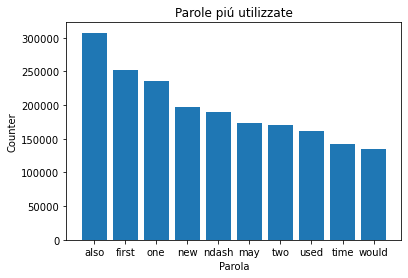

In [9]:
data = pd.read_csv('singleWordCounted.csv')
data = data.sort_values(by=['total_count'], ascending=False)
data = data.head(10)
x = data['word']
y = data['total_count']

plt.bar(x, y)
plt.title('Parole piú utilizzate')
plt.xlabel('Parola')
plt.ylabel('Counter')
plt.show()

Creazione di un grafico che mostra quale parola viene utilizzata in piú titoli.
\
Utilizza lo split per dividere le varie parole contenute nella colonna "titles" visto che sono divise da una virgola.
\
Creato utilizzando il file [titlesSize.csv](./titlesSize.csv).

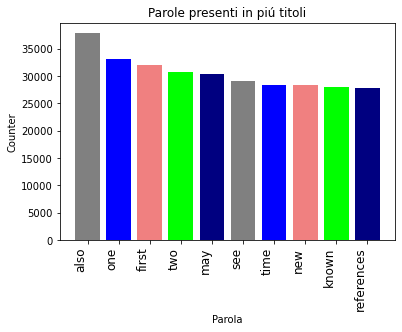

In [10]:
df = pd.read_csv('titlesSize.csv')

df_sorted = df.sort_values('list_size', ascending=False)

colori = ['grey', 'blue', 'lightcoral', 'lime', 'navy']
df_words = df_sorted.head(10)['word'].tolist()
df_counts = df_sorted.head(10)['list_size'].tolist()

plt.bar(df_words, df_counts, color = colori)
plt.title('Parole presenti in piú titoli')
plt.xlabel('Parola')
plt.ylabel('Counter')
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='normal',
    fontsize='large'  
)

plt.show()

Grafico che tiene conto dei (n) titoli per singola parola. Se ad esempio, ci sono 5 parole che contengono 1 titolo, nell'asse x rappresenteremo il numero di parole per titolo. Nell'asse y invece il numero di titoli che contengono quelle n parole.
\
Crea il grafico analizzando i dati contenuti in [occurrences.csv](./occurrences.csv).

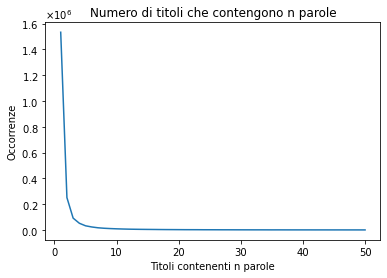

In [11]:
data = pd.read_csv('occurrences.csv')
data = data.head(50)
x = data['list_size'].tolist()
y = data['occurrences'].tolist()

plt.plot(x,y)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.xlabel('Titoli contenenti n parole')
plt.ylabel('Occorrenze')
plt.title('Numero di titoli che contengono n parole')

plt.show()

Come sopra ma teniamo conto <i>SOLO</i> dei primi 5 elementi.

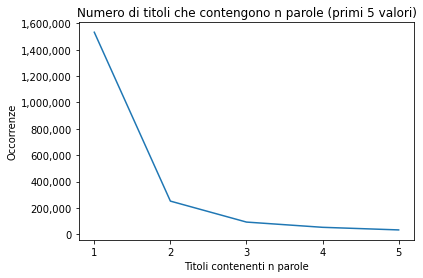

In [12]:
data = pd.read_csv('occurrences.csv')
data = data.head(5)
x = data['list_size'].tolist()
y = data['occurrences'].tolist()

fig, plot = plt.subplots()

plot.plot(x,y)

# formatta l'asse x
plot.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))

# formatta l'asse y
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
plot.yaxis.set_major_formatter(tick)

plt.xlabel('Titoli contenenti n parole')
plt.ylabel('Occorrenze')
plt.title('Numero di titoli che contengono n parole (primi 5 valori)')

plt.show()

Raggruppiamo le lettere iniziali delle parole in base al numero di volte che sono state utilizzate.

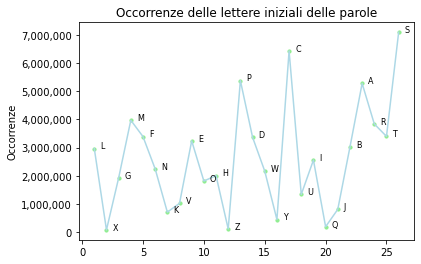

In [13]:
data = pd.read_csv('initialLetter.csv')

x = data['char'].tolist()
y = data['occurrences'].tolist()
count = range(1,27)

fig, plot = plt.subplots()

plot.scatter(count, y, color = 'lightgreen',  s=10, marker="o")

# formatta l'asse x
fmt = '{:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
plot.yaxis.set_major_formatter(tick)

# formatta l'asse y
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
plot.yaxis.set_major_formatter(tick)

plt.ylabel('Occorrenze')
plt.title('Occorrenze delle lettere iniziali delle parole')

for i in range(len(x)):
    plt.annotate(x[i].upper(), (count[i]+0.5, y[i]), fontsize=8)
plt.plot(count, y, color = 'lightblue')

plt.show()

---

<h2>Cella per la rimozione dei files.</h2>

In [14]:
spark.stop()

question = "Vuoi rimuovere tutti i file con estensione CSV creati? [y/n]"
choise = input(question).lower()
while True: 
    if choise == "y" or choise == "yes":
        for x in os.listdir():
            if x.endswith(".csv"):
                os.remove(x)
        print("File rimossi con successo!")
        break
    if choise == "n" or choise == "no":
        print("Attenzione! I files non sono stati rimossi!")
        break
    else:
        print("Comando non riconosciuto!", end = '\r') 
        print(choise, end='')
        choise = input(question).lower()

File rimossi con successo!
